# Stock Market Pattern Detection using Quantum Kernel PCA


In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.decomposition import KernelPCA
import pennylane as qml
from pennylane import numpy as pnp
import time

In [2]:
TICKER = "AAPL"
PERIOD = "5y" # example: '5y', '2y', '1y'
INTERVAL = "1d"
FEATURE_COLS = ['logret','ma_5','ma_20','vol_20','momentum_5']
N_QUBITS = 4 # change based on simulator/hardware limits
SUBSET_SIZE = 200 # compute kernel on the last SUBSET_SIZE samples for speed
SEED = 42
np.random.seed(SEED)

In [3]:
def fetch_and_feature(ticker=TICKER, period=PERIOD, interval=INTERVAL):
    df = yf.download(ticker, period=period, interval=interval, auto_adjust=True)
    df = df.dropna()
    df['returns'] = df['Close'].pct_change().fillna(0)
    df['logret'] = np.log1p(df['returns'])
    df['ma_5'] = df['Close'].rolling(5).mean()
    df['ma_20'] = df['Close'].rolling(20).mean()
    df['vol_20'] = df['logret'].rolling(20).std()
    df['momentum_5'] = df['Close']/df['Close'].shift(5) - 1
    df = df.dropna()
    return df

In [4]:
print(f"Fetching {TICKER} {PERIOD} {INTERVAL}...")
df = fetch_and_feature()
print(f"Data shape: {df.shape}")
df.head()

Fetching AAPL 5y 1d...


[*********************100%***********************]  1 of 1 completed

Data shape: (1237, 11)


Price,Close,High,Low,Open,Volume,returns,logret,ma_5,ma_20,vol_20,momentum_5
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,,,,,,
Date,,,,,,,,,,,
2020-12-07,120.581490,121.380494,119.119896,119.178357,86712000,0.012270,0.012195,119.800027,115.922912,0.014143,0.039479
2020-12-08,121.195358,121.780002,119.938387,121.185620,82225500,0.005091,0.005078,120.123526,116.315593,0.014130,0.013527
2020-12-09,118.661942,122.725171,117.901914,121.341530,115089200,-0.020904,-0.021125,119.870181,116.598655,0.015106,-0.010562
2020-12-10,120.084549,120.698423,117.073669,117.414706,81312200,0.011989,0.011917,119.928645,116.781353,0.013871,0.002440
2020-12-11,119.275810,119.616847,117.463433,119.295295,86939800,-0.006735,-0.006758,119.959830,116.937256,0.013970,0.001309


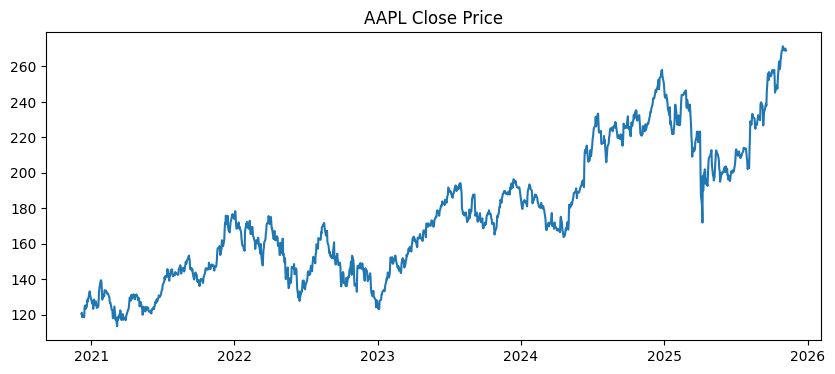

In [5]:
plt.figure(figsize=(10,4))
plt.plot(df['Close'])
plt.title(f"{TICKER} Close Price")
plt.show()

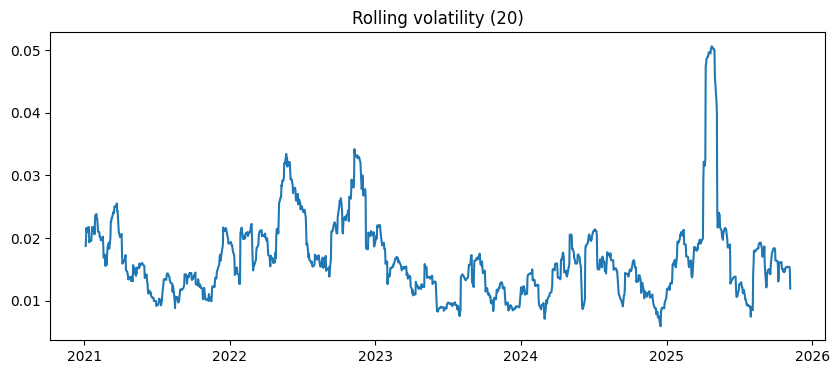

In [6]:
plt.figure(figsize=(10,4))
plt.plot(df['logret'].rolling(20).std())
plt.title("Rolling volatility (20)")
plt.show()

In [7]:
X = df[FEATURE_COLS].values
scaler = StandardScaler()
Xs = scaler.fit_transform(X)

In [8]:
pca = PCA(n_components=min(3, Xs.shape[1]))
Z_classic = pca.fit_transform(Xs)
print("Classical PCA explained variance ratio:", pca.explained_variance_ratio_)

Classical PCA explained variance ratio: [0.40688706 0.28590553 0.19081251]


In [9]:
from sklearn.decomposition import PCA as SKPCA
if Xs.shape[1] > N_QUBITS:
    print(f"Reducing feature dimension {Xs.shape[1]} -> {N_QUBITS} using PCA")
    reducer = SKPCA(n_components=N_QUBITS)
    Xq = reducer.fit_transform(Xs)
elif Xs.shape[1] < N_QUBITS:
    print(f"Padding feature dimension {Xs.shape[1]} -> {N_QUBITS} with zeros")
    pad = np.zeros((Xs.shape[0], N_QUBITS - Xs.shape[1]))
    Xq = np.hstack([Xs, pad])
else:
    Xq = Xs.copy()

Reducing feature dimension 5 -> 4 using PCA


In [10]:
mms = MinMaxScaler(feature_range=(0, np.pi))
Xq_scaled = mms.fit_transform(Xq)

In [11]:
X_sub = Xq_scaled[-SUBSET_SIZE:]
sub_index = df.index[-SUBSET_SIZE:]
print("Subset shape for kernel:", X_sub.shape)

Subset shape for kernel: (200, 4)


In [12]:
dev = qml.device('default.qubit', wires=N_QUBITS)

In [13]:
@qml.qnode(dev)
def state_vector_circuit(x):
# x length must be N_QUBITS
    for i in range(N_QUBITS):
        qml.RY(float(x[i]), wires=i)
    # simple entangler chain
    for i in range(N_QUBITS-1):
        qml.CNOT(wires=[i, i+1])
    return qml.state()

In [14]:
print('device and qnode ready')

device and qnode ready


In [15]:
def compute_kernel_matrix(X_in, progress=False):
    m = X_in.shape[0]
    states = []
    t0 = time.time()
    for i in range(m):
        states.append(state_vector_circuit(X_in[i]))
        if progress and (i+1) % 20 == 0:
            print(f"Prepared {i+1}/{m} statevectors")
    K = np.zeros((m,m), dtype=float)
    for i in range(m):
        for j in range(i, m):
            fid = np.abs(np.vdot(states[i], states[j]))**2
            K[i,j] = fid
            K[j,i] = fid
    t1 = time.time()
    print(f"Kernel matrix computed in {t1-t0:.2f}s")
    return K

In [16]:
K = compute_kernel_matrix(X_sub, progress=True)

Prepared 20/200 statevectors
Prepared 40/200 statevectors
Prepared 60/200 statevectors
Prepared 80/200 statevectors
Prepared 100/200 statevectors
Prepared 120/200 statevectors
Prepared 140/200 statevectors
Prepared 160/200 statevectors
Prepared 180/200 statevectors
Prepared 200/200 statevectors
Kernel matrix computed in 0.40s


In [17]:
kpca = KernelPCA(n_components=3, kernel='precomputed')
Zq = kpca.fit_transform(K)
print('Quantum-kernel PCA embedding shape:', Zq.shape)

Quantum-kernel PCA embedding shape: (200, 3)


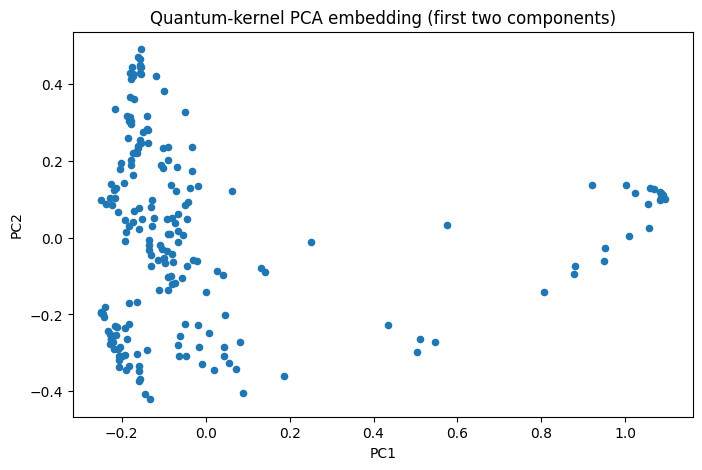

In [18]:
plt.figure(figsize=(8,5))
plt.scatter(Zq[:,0], Zq[:,1], s=20)
plt.title('Quantum-kernel PCA embedding (first two components)')
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.show()

In [19]:
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=SEED).fit(Zq)
clusters = kmeans.labels_

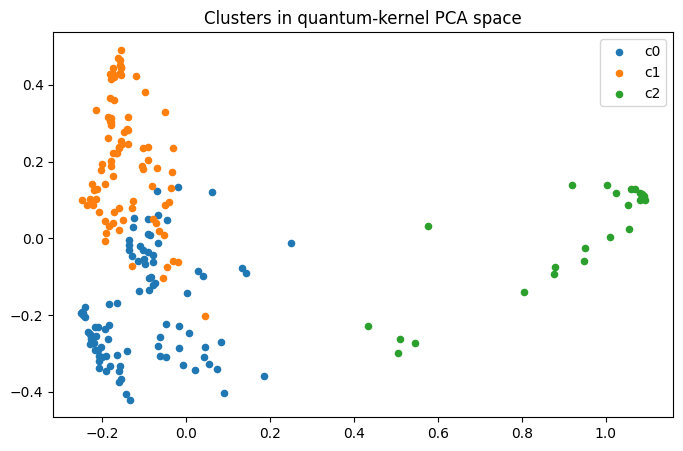

In [20]:
plt.figure(figsize=(8,5))
for c in range(n_clusters):
    idx = clusters == c
    plt.scatter(Zq[idx,0], Zq[idx,1], label=f'c{c}', s=20)
plt.legend(); plt.title('Clusters in quantum-kernel PCA space')
plt.show()

In [21]:
cluster_series = pd.Series(clusters, index=sub_index)
cluster_series.value_counts()

0    91
1    85
2    24
Name: count, dtype: int64

In [22]:
forward_returns = df['returns'].loc[sub_index].shift(-1).fillna(0) # next-day returns
cluster_perf = {}
for c in range(n_clusters):
    mask = cluster_series == c
    cluster_perf[c] = forward_returns[mask].mean()
print('Cluster forward mean returns:', cluster_perf)
# choose cluster with highest mean forward return as long signal
best_cluster = max(cluster_perf, key=cluster_perf.get)
print('Selected long cluster:', best_cluster)

Cluster forward mean returns: {0: np.float64(0.001439825714774012), 1: np.float64(0.0013699765700319081), 2: np.float64(-0.00031620446854799256)}
Selected long cluster: 0


In [23]:
signals = (cluster_series == best_cluster).astype(int)

In [24]:
def backtest_signals(signals, returns, cost_per_trade=0.0005):
    # signals: 0/1 series aligned to dates
    # returns: daily returns series aligned to dates
    # we take position at close of day t to capture return on t+1 -> shift signals
    pos = signals.shift(1).fillna(0)
    strat_rets = pos * returns
    # transaction costs when position changes (enter/exit)
    trades = pos.diff().abs()
    strat_rets = strat_rets - trades * cost_per_trade
    eq = (1 + strat_rets).cumprod()
    return strat_rets, eq

In [25]:
rets_sub = df['returns'].loc[sub_index]
strat_rets, equity = backtest_signals(signals, rets_sub)

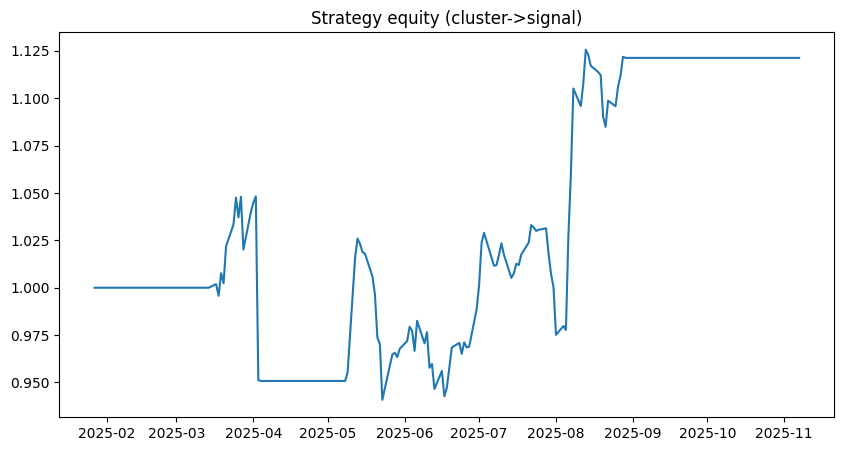

In [26]:
plt.figure(figsize=(10,5))
plt.plot(equity.index, equity.values)
plt.title('Strategy equity (cluster->signal)')
plt.show()

In [27]:
def sharpe_ratio(returns, freq=252):
    return returns.mean() / (returns.std()+1e-9) * np.sqrt(freq)

In [28]:
print('Strategy Sharpe:', sharpe_ratio(strat_rets))
print('Strategy total return:', equity.iloc[-1]-1)

Strategy Sharpe: 0.8537590553404735
Strategy total return: 0.12126756808734518


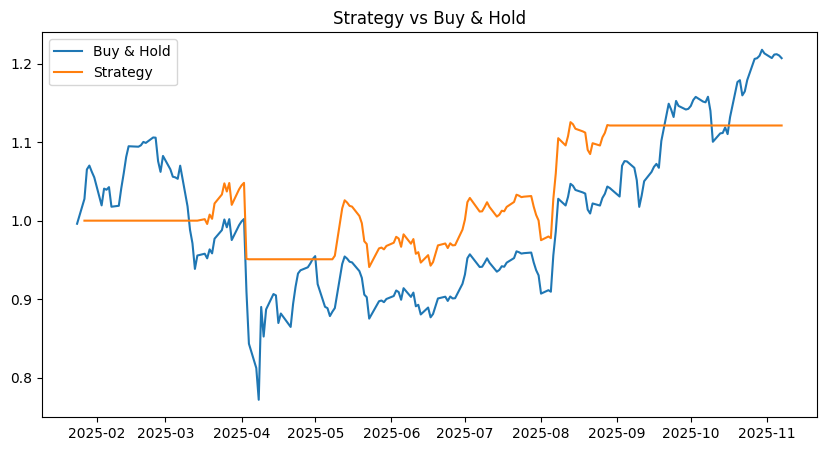

In [29]:
bh = (1 + rets_sub).cumprod()
plt.figure(figsize=(10,5))
plt.plot(bh.index, bh.values, label='Buy & Hold')
plt.plot(equity.index, equity.values, label='Strategy')
plt.legend(); plt.title('Strategy vs Buy & Hold')
plt.show()

In [30]:
out = pd.DataFrame(index=sub_index)
out['cluster'] = cluster_series
out['signal'] = signals
out['returns'] = rets_sub
out['strategy_returns'] = strat_rets
out['equity'] = equity
out.to_csv('quantum_pca_strategy_results.csv')
print('Saved results -> quantum_pca_strategy_results.csv')

Saved results -> quantum_pca_strategy_results.csv


In [31]:
def run_quantum_pca_pipeline(ticker=TICKER, period=PERIOD, n_qubits=N_QUBITS, subset_size=SUBSET_SIZE):
    df_local = fetch_and_feature(ticker, period)
    X = df_local[FEATURE_COLS].values
    Xs = StandardScaler().fit_transform(X)
    # reduce/pad
    if Xs.shape[1] > n_qubits:
        Xq = SKPCA(n_components=n_qubits).fit_transform(Xs)
    elif Xs.shape[1] < n_qubits:
        pad = np.zeros((Xs.shape[0], n_qubits - Xs.shape[1]))
        Xq = np.hstack([Xs, pad])
    else:
        Xq = Xs.copy()
    Xq_scaled = MinMaxScaler((0, np.pi)).fit_transform(Xq)
    X_sub = Xq_scaled[-subset_size:]
    idx = df_local.index[-subset_size:]
    K = compute_kernel_matrix(X_sub)
    Zq = KernelPCA(n_components=3, kernel='precomputed').fit_transform(K)
    kmeans = KMeans(n_clusters=3, random_state=SEED).fit(Zq)
    clusters = pd.Series(kmeans.labels_, index=idx)
    # pick best cluster
    forward_returns = df_local['returns'].loc[idx].shift(-1).fillna(0)
    cluster_perf = {c: forward_returns[clusters==c].mean() for c in range(3)}
    best = max(cluster_perf, key=cluster_perf.get)
    signals = (clusters==best).astype(int)
    strat_rets, equity = backtest_signals(signals, df_local['returns'].loc[idx])
    return {
    'df': df_local,
    'subset_index': idx,
    'K': K,
    'Zq': Zq,
    'clusters': clusters,
    'signals': signals,
    'strat_rets': strat_rets,
    'equity': equity
    }

In [32]:
results = run_quantum_pca_pipeline()
print(results['equity'].iloc[-1])

[*********************100%***********************]  1 of 1 completed


Kernel matrix computed in 0.40s
1.1212675680873452
